In [ ]:
# 목적: 서로 다른 4개의 신문사 (경향, 동아, 조선, 한겨레)에서 작성한 ‘조국’ 관련 기사를 분석하여 
# 해당 사건을 바라보는 '신문사별 관점과 시각이 차이가 나는지'를 알아보는 것

# 방법
# 1. '각 신문사'의 5개의 기사 내용 수집하기 (기사의 url 주소는 첨부파일 참조)
# 2. '각 신문사 별'로 단어 빈도 분석 하기
#    분석 품사: 명사, 형용사, 동사
# 3. 네트워크 분석을 사용하여 ‘조국’ 라는 단어와 자주 같이 사용된 단어가 무엇인지를 파악 (명사 단어만 사용)


# ** 네이버 기사를 web scraping 기법을 사용한다. 수업에서 사용된 코드를 사용해도 된다.
# ** 각 품사에 따라 별도로 분석하고 품사별로 차이가 나는지 파악
# ** 차이가 있는가? 없는가?  있다면, 어떠한 차이가 있는가? 없다면, 왜 차이가 없게 결과가 나왔다고 생각하는가


In [14]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import os
import re

from collections import Counter

import matplotlib.pyplot as plt

from IPython.display import Image

import itertools

%matplotlib inline

In [2]:
# pip install customized_konlpy
import konlpy.tag
from ckonlpy.tag import Twitter as cTwitter

In [3]:
# matplotlib 한글 폰트 출력코드
# 출처 : 데이터공방( https://kiddwannabe.blog.me)

import matplotlib
from matplotlib import font_manager, rc
import platform

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False  



# 기사 URL

In [4]:
url_news = {
    # 조선일보 뉴스
    "chosun" : [
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=023&aid=0003617518",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617671",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=023&aid=0003617508",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617441",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617684"
    ],

    # 동아일보 뉴스
    "donga" : [
       "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361331",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361343",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361101",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=020&aid=0003361355",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361148"
    ],

    # 한겨례 뉴스
    "hankyoreh" : [
       "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=028&aid=0002546872",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=028&aid=0002546783",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=028&aid=0002546537",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=028&aid=0002546230",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=028&aid=0002546450",
    ],

    # 경향뉴스
    "kyunghyang" : [
       "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003077659",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003077465",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003077427",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003077679",
        "https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003077653"
    ]

}


name_news = {
    "chosun" : "조선일보",
    "donga" : "동아일보",
    "hankyoreh" : "한겨레신문",
    "kyunghyang" : "경향일보"
}

name_pos = {
    "Noun" : "명사",
    "Adjective" : "형용사",
    "Verb" : "동사"
}

In [5]:
# 제거할 패턴들 정의 (금칙어)
except_words = [ 
    r'\D+}\s\s',
    r'\[\D+\]',
    r'Copyrights\D+',
    r'사진\=뉴스타파',
    r'\/뉴시스',
    r'\/뉴스타파',
    r'뉴스타파 캡처',
    r'<사진>',
    r'사진\=',
    r'캡처',
    r'.\w{3} 동아닷컴 기자 \D+',
    r'.\w{3} \w+@donga.com\D+',
    r'.(\s)\w+@donga.com\D+',
    r'.\w{2}\/\w{3} 기자 \w+@hani.co.kr',
    r'\w{3} \w{3} \w{3} 기자 \w+@hani.co.kr',
    r'\w{3} 기자 \w+@hani.co.kr',
    r'▶ \D+',
    r'\w{3} 기자 \w+@kyunghyang.com',
    r'\w{3}·\w{3} 기자  \w+@kyunghyang.com',
    r'\t',
    '윤민혁 기자',
    '조선일보',
    '동아일보',
    '한겨레',
    '경향신문'
]

# 치환할 패턴
other_words1 = ['조국', '조 국', '조국 전 법무부 장관', '조 전 장관', '조국 전 법무장관', '조씨']


In [6]:
headers = {
    'referer' : 'https://search.naver.com',
    'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36'
}

## 특정 기사 (url) 크롤링
- 전처리 포함

In [7]:
def get_article(url):
    print('CRAWLING:', url)
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    #print(soup)
#     print(soup.title.text)

    # <script> <style> 제거 (전처리)
    for s in soup(['script', 'style']):
        s.decompose()
    
    # 뉴스본문 리턴
    news_content = soup.find('div', attrs = {'id': 'articleBodyContents'})
    
    # 뉴스본문에 대한 전처리
    # 각 line 별로 strip(), 태그 제거
    lines = [
        line.strip()
        for line in news_content.get_text().splitlines()
    ]
    news_content = ''.join(lines)
    
    # 구두점 제거 
    news_content = news_content.replace(',', ' ').\
        replace("'"," ").replace('·', ' ').replace('=',' ').replace('\t', ' ').replace('\"', '')
    
    # 제거 패턴
    for ex_word in except_words:
        news_content = re.sub(ex_word, '', news_content)
    
    # 치환할 패턴
    for other_word in other_words1:
        news_content = re.sub(other_word, '조국', news_content)
        
    return news_content
    
# get_article(url_news['chosun'][0])

In [8]:
# 신문사별 크롤링 결과 담을 dict
news_article = {}

for newspaper in url_news:
    print(newspaper)
    url_list = url_news[newspaper]
    for url in url_list:
        if not newspaper in news_article:
            news_article[newspaper] = []
            
        news_article[newspaper].append(get_article(url))


chosun
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=023&aid=0003617518
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617671
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=023&aid=0003617508
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617441
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=023&aid=0003617684
donga
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361331
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361343
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361101
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=020&aid=0003361355
CRAWLING: https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=020&aid=0003361148
hankyoreh
CRAWLING: https:/

In [9]:
news_article['donga'][2]

'신경민 전 더불어민주당 의원이 조국의 회고록 ‘조국의 시간’ 출간에 대해 “걱정하고 우려하고  하여튼 불편한 얘기들이 굉장히 많다”고 당내 분위기를 전했다. 신 전 의원은 31일 오후 방송된 CBS 라디오 ‘김종대의 뉴스업’에서 “지금 당내에서 두 가지를 놓고 지적이 일고 있다”며 “첫 번째 질문은 ‘꼭 책을 내야만 했느냐’이고  두 번째 질문은 ‘왜 지금이냐’는 거다”라고 말했다.그는 “지금 재판이 계류 중이고  재판이 부인 것까지 하면 1~2건이 아니고 굉장히 복잡하게 법률적으로 얽혀 있어서 정리하기가 쉽지 않은 판인데  재판 중에 법정에서 변호인을 통해서 해야 할 얘기를 본인이 굉장히 제한적으로 얘기하면서 책으로 이렇게 써야 될 만큼 뭔 긴박한 일이 있었느냐라는 것이다”고 지적했다.이어 “두 번째는 4.7재보궐에서 참패를 했다. 그리고 지금 막 대선 진행을 시작했기 때문에 9월 전당대회에서 어떤 결론을 내느냐는 게 일단 굉장히 중요한 매듭이다”며 “이 대목에서 조국의 이슈가 조국-윤석열  추미애-윤석열 대결까지 겹쳐서 굉장히 논란이다”고 말했다.(신경민 전 더불어민주당 의원)또 “(조-윤 추-윤 대결)그 몇 년이라는 기간이 문재인 정부에 아주 굉장히 중요한 기간이었고 이것을 내년 3월 대선에서 또 총정리를 해야 될 판인데  다시 이것을 꺼내서 또 논란을 일으키고”라고 꼬집었다.그는 “조국 개인적 입장에서는 억울한 대목도 있어 얘기 하고 싶겠지만 이렇게 되면 또 윤석열이라는 이름이 전면에 등장하게 되고 조국의 공정성 문제가 다시 도마 위에 올라가고  두 가지 이유로 봤을 때 지금 이 시점에서 맞느냐 하는 얘기가 당내에 지금 있다”고 전했다'

## 2. 신문사별 & 품사별 빈도수

In [10]:
twitter = cTwitter()

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [30]:
twitter.pos('정을영')

[('정', 'Noun'), ('을', 'Josa'), ('영', 'Noun')]

In [31]:
twitter.add_dictionary('정을영', 'Noun')

In [32]:
twitter.pos('정을영')

[('정을영', 'Noun')]

In [11]:
# 품사 분류되길 원하는 단어를 품사로 등록해주길
twitter.add_dictionary('조국', 'Noun')

In [12]:
#  언론사별 x 품사별(명사, 형용사, 동사) 등장빈도 통계
#  등장빈도 상위 20개
#  단어길이는 2글자 이상만.

# 결과를 시각화, 엑셀 저장

In [15]:
out_path = r'D:\DevRoot\DataSet\news_network'
if not os.path.exists(out_path):
    os.makedirs(out_path)
    print(out_path, '생성')

chosun Noun
chosun Adjective
chosun Verb
donga Noun
donga Adjective
donga Verb
hankyoreh Noun
hankyoreh Adjective
hankyoreh Verb
kyunghyang Noun
kyunghyang Adjective
kyunghyang Verb


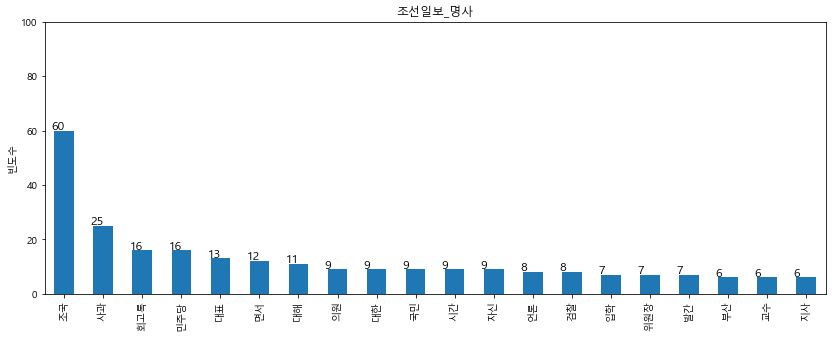

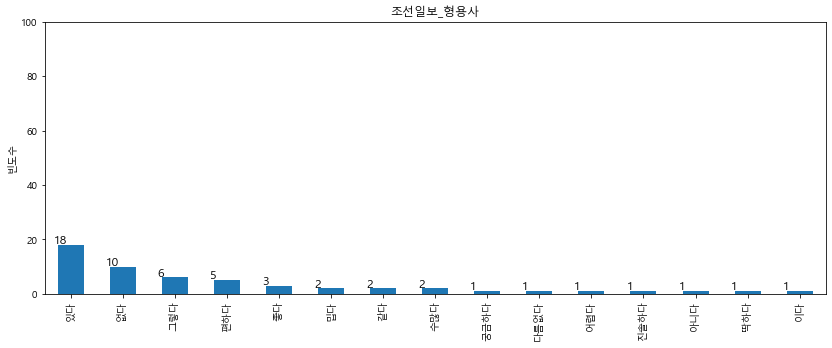

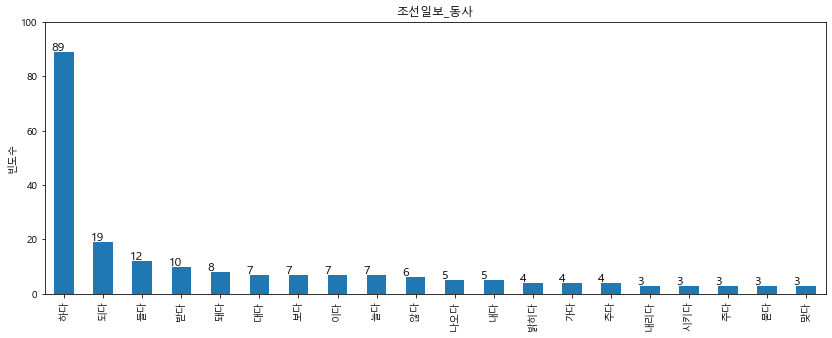

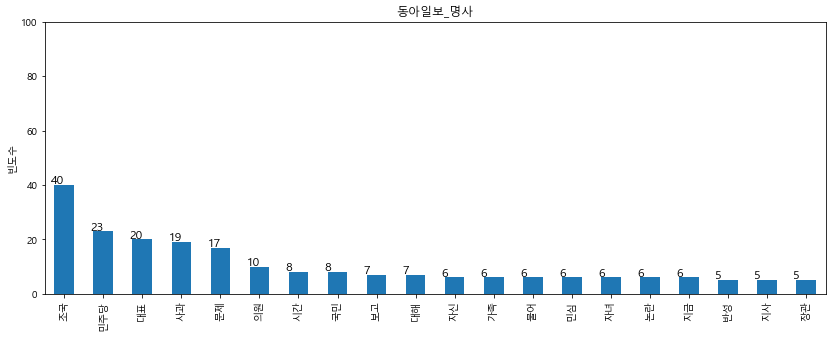

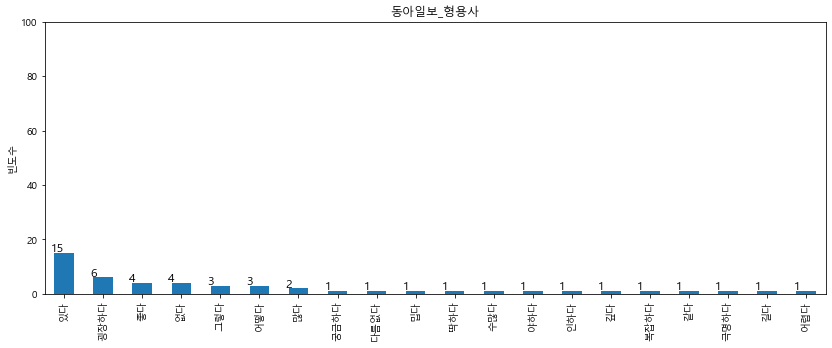

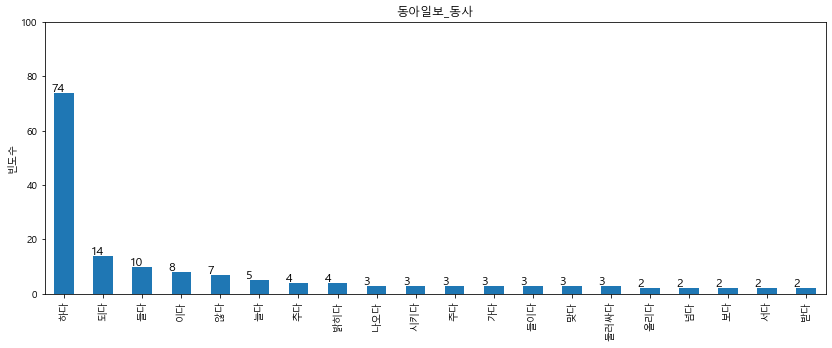

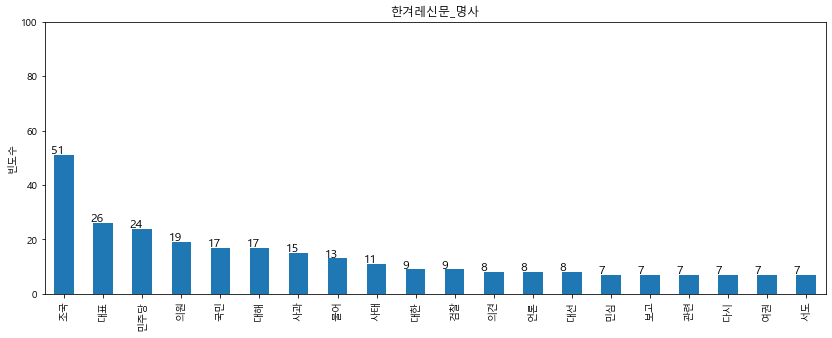

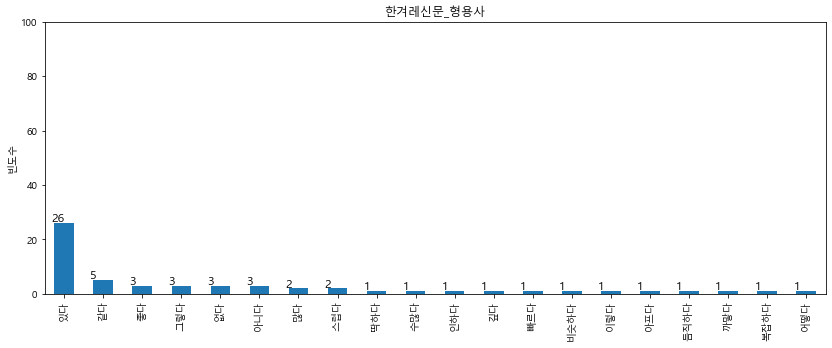

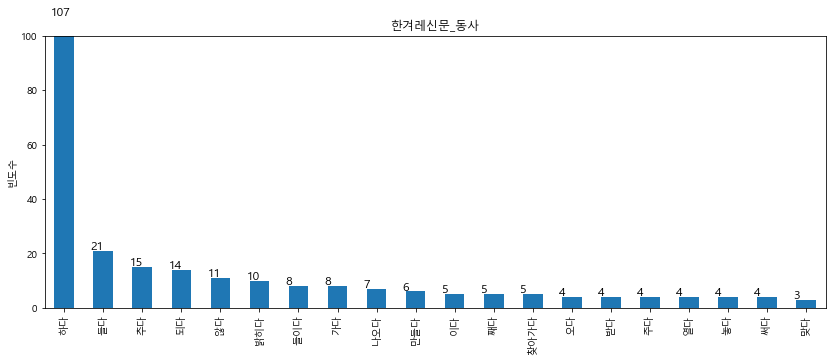

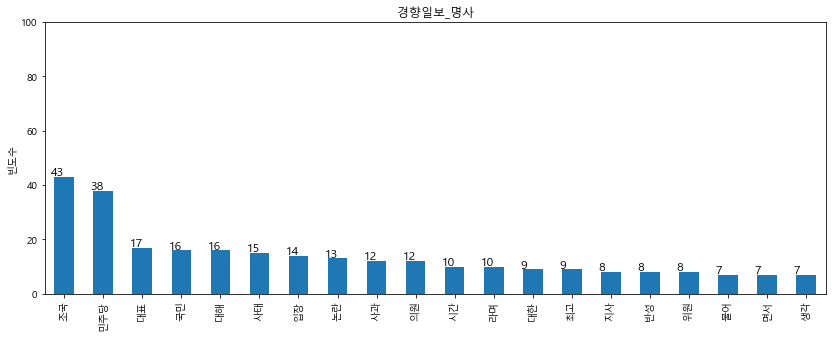

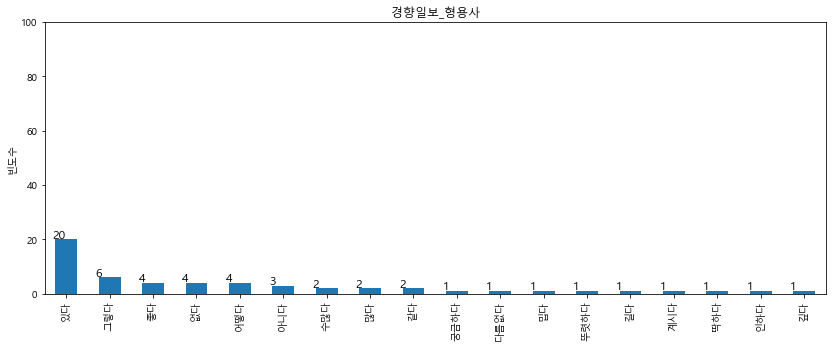

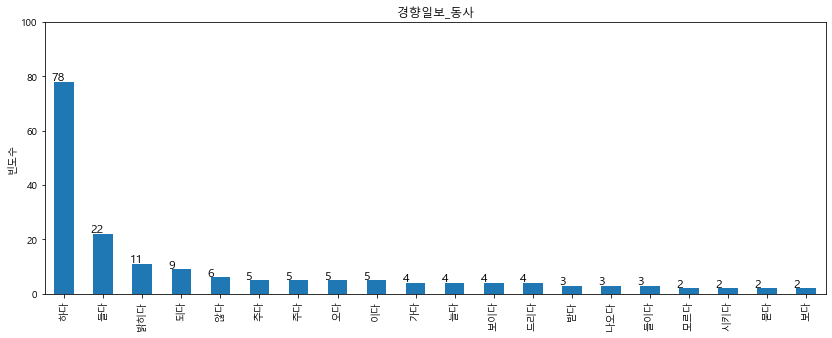

In [36]:
# 언론사별.
for newspaper in news_article:

    # '언론사별' 로 기사 텍스트 합치기
    article = "".join(news_article[newspaper])
    
    # 기사의 어휘소 분석
    twitter_morphs = twitter.pos(article, norm=True, stem=True)
    
    # 품사별 분리
    for pos in name_pos:  # "Noun", "Adjective", "Verb"  통계검색할 품사들
        
        print(newspaper, pos)
        
        pos_words = []
        
        for mal in twitter_morphs:   # mal <= (단어, 품사)
            if pos == mal[1] and len(mal[0]) > 1:   # 통계검색할 품사들만 and 단어길이가 2글자 이상만.
                pos_words.append(mal[0])  # 단어 추가
                
        pos_counter = Counter(pos_words)  # 해당 품사의 단어 빈도수 파악
        
#         print(pos_counter)
#         print(pos_counter.most_common(20))

        # 파일저장및 시각화를 위한 DataFrame 만들기
        df_freq = pd.DataFrame(columns = ['word', 'count'])
        
        for freq_words in pos_counter.most_common(20):  # 최다 빈소 상위20개 추출
            df_freq.loc[len(df_freq)] = (freq_words[0], freq_words[1])
        
        # 파일 저장
        df_freq = df_freq.set_index('word')  # 기존의 index 없애고 word 컬럼을 index 로 변경
        out_file = os.path.join(out_path, f'{name_news[newspaper]}_{name_pos[pos]}.csv' )
        df_freq.to_csv(out_file, encoding='euc-kr')
        
        #시각화
        plt.rcParams["figure.figsize"] = (14, 5)  # 그래프의 가로 세로 사이즈 기본설정
        ax = df_freq.plot(kind="bar")
        ax.set_title(f'{name_news[newspaper]}_{name_pos[pos]}') # 그래프 제목
        ax.set_xlabel("")
        ax.set_ylabel("빈도수")
        ax.legend().set_visible(False) # 범례 없애기
        ax.set_ylim(0, 100)   # y 축 값 범위
        
        for i in ax.patches:  # 그래프에 해당 숫자 값 표시
            ax.text(
                i.get_x() - .08,  # 표시할 x좌표
                i.get_height() + .5,  # 표시할 y좌표
                i.get_height(),      # 표시할 값
                fontsize = 12,
                color = 'black'
            )
            
        
        # 시각화 이미지 저장
        out_file = os.path.join(out_path,  f'{name_news[newspaper]}_{name_pos[pos]}.png')
        ax.get_figure().savefig(out_file, dpi=200)
        
    

In [24]:
Counter([1, 2, 1, 1, 1, 3, 3, 2, 2, 1, 1, 1])

Counter({1: 7, 2: 3, 3: 2})